In [1]:
# ref : https://www.kaggle.com/uciml/pima-indians-diabetes-database?select=diabetes.csv

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# 1. 데이터 사전 탐색(EDA)

In [3]:
df = pd.read_csv('diabetes.csv')

In [4]:
df.shape

(768, 9)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


* Pregnancies : 임신횟수
* Glucose : 포도당수치
* BloodPressure : 혈압
* SkinThickness : 피하지방
* Insulin : 인슐린
* BMI : 체질량지수
* DiabetesPedigreeFunction : 유전적(가족력)
* Age : 나이
* Outcome : 당뇨여부 1(당뇨) / 0(정상)

## 무조건 점수부터 보자 (결측없다, 수치형피쳐)

In [7]:
def myfit(df_X, df_y, model, imp=0, tsize=0.2):
    X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=tsize, random_state=36,  shuffle=False)
    #print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    accuracy = accuracy_score(pred ,  y_test)
    precision = precision_score(pred ,  y_test)
    recall = recall_score(pred ,  y_test)
    f1 = f1_score(pred ,  y_test)
    print("Accuracy:{:.6f}  precision:{:.6f}, recall:{:.6f}, f1:{:.6f}".format(accuracy, precision, recall, f1))
    
#     if imp==1:
#         imp_df = pd.DataFrame({"featuer" : X_train.columns, "importance" : model.feature_importances_})
#         imp_df = imp_df.sort_values('importance', ascending=False).T
#         print(imp_df)

In [8]:
rf = RandomForestClassifier(random_state=36)
df_y = df["Outcome"]
df_X = df.drop("Outcome", axis=1)
print(df_X.shape, df_y.shape)

(768, 8) (768,)


In [9]:
myfit(df_X, df_y, rf, imp=1)   # 0.720779

Accuracy:0.766234  precision:0.545455, recall:0.731707, f1:0.625000


## 불균형 확인

In [10]:
df["Outcome"].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

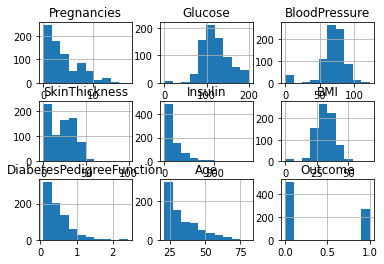

In [11]:
df.hist()
plt.show()

### 0데이터 확인

In [12]:
nan_dict = {"CNT":df.isin([0]).sum(),
            "RATE": df.isin([0]).sum()/df.shape[0] *100
}
nan_df = pd.DataFrame(nan_dict)
print(nan_df[nan_df["RATE"]>0].sort_values("CNT", ascending=False))


               CNT       RATE
Outcome        500  65.104167
Insulin        374  48.697917
SkinThickness  227  29.557292
Pregnancies    111  14.453125
BloodPressure   35   4.557292
BMI             11   1.432292
Glucose          5   0.651042


* Insulin        374  48.697917
* SkinThickness  227  29.557292  --??
* BloodPressure   35   4.557292
* BMI             11   1.432292
* Glucose          5   0.651042

### 각 피쳐당 0값을 평균값으로 대체

In [13]:
zero_feature = ["Insulin","SkinThickness","BloodPressure","BMI","Glucose"]
zero_mean = df[zero_feature].mean()
df[zero_feature] = df[zero_feature].replace(0, zero_mean)

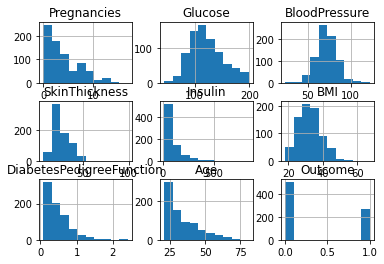

In [14]:
df.hist()
plt.show()

In [15]:
df.head()  

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.000000,79.799479,33.6,0.627,50,1
1,1,85.0,66.0,29.000000,79.799479,26.6,0.351,31,0
2,8,183.0,64.0,20.536458,79.799479,23.3,0.672,32,1
3,1,89.0,66.0,23.000000,94.000000,28.1,0.167,21,0
4,0,137.0,40.0,35.000000,168.000000,43.1,2.288,33,1


In [16]:
def myscore(y_test,pred,proba, pr_curve=0, auc_curve=0):
    accuracy = accuracy_score(pred ,  y_test)
    precision = precision_score(pred ,  y_test)
    recall = recall_score(pred ,  y_test)
    f1 = f1_score(pred ,  y_test)
    auc = roc_auc_score(y_test, proba[:,-1])
    #print(f'StandardScaler:  {df_score:.4f}')  # 0.766234
    #print(f"Accuracy:{accuracy:.6f}  precision:{precision:.6f}, recall:{recall:.6f}, f1:{f1:.6f}")
    print("Accuracy:{:.6f}  precision:{:.6f}, recall:{:.6f}, f1:{:.6f}, auc:{:.6f}".format(accuracy, precision, recall, f1, auc))
    
    mtx = confusion_matrix(y_test, pred)
    print(mtx)
    
    if pr_curve==1:
        mycurve(y_test, proba)
    if auc_curve==1:
        mycurve_auc(y_test, proba)
        

In [17]:
from sklearn.metrics import precision_recall_curve
def mycurve(y_test, proba):  
    precision, recall, thresholds = precision_recall_curve(y_test, proba[ : , -1])
    print(len(precision), len(recall), len(thresholds))  #66 66 65
    plt.plot(thresholds, precision[:len(thresholds)], label="precision")
    plt.plot(thresholds, recall[:len(thresholds)], label="recall")
    plt.xlabel("thresholds")
    plt.ylabel("score")
    plt.grid()
    plt.legend()
    plt.show()
    
    

In [18]:
def mycurve_auc(y_test, proba):  
    fpr, tpr, thresholds = roc_curve(y_test, proba[:,-1])
    print(len(fpr), len(tpr), len(thresholds))  #66 66 65
    plt.plot(fpr, tpr, label="roc")
    plt.plot([0,1], [0,1], label="th:0.5")
    plt.xlabel("FPR (1-TNR(specificity)")      #FP
    plt.ylabel("TPR (recall,sensitivity)") #TP
    plt.title(f"auc : {roc_auc_score(y_test, proba[:,-1]):.4f}")
    plt.grid()
    plt.legend()
    plt.show()

## 스케일링 : 정규화

### 방법1) df_X.splite -->  train.fit_transform  --> test.transform

Accuracy:0.740260  precision:0.545455, recall:0.666667, f1:0.600000, auc:0.818090
[[84 15]
 [25 30]]
66 66 65


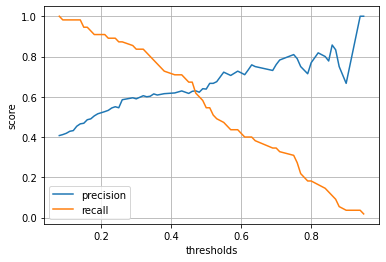

64 64 64


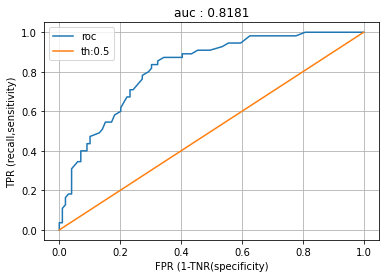

In [19]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
df_y = df["Outcome"]
df_X = df.drop("Outcome", axis=1)
     
std_scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=36,  shuffle=False)
# print(X_train.shape, X_test.shape, len(y_train), len(y_test))

std_scaler = StandardScaler()
X_train_scaler = std_scaler.fit_transform(X_train)  
X_test_scaler  = std_scaler.transform(X_test)    #---------------------스케일링 1/10 적용

rf.fit(X_train_scaler, y_train)
pred = rf.predict(X_test_scaler)
proba= rf.predict_proba(X_test_scaler)

#-------------------------------------------------
# print(pred[:5], proba[:5])
myscore(y_test,pred, proba, pr_curve=1, auc_curve=1)
          
    

* ROC곡선 : FPR 0~1변화에 따른 TPR 변환율
* FPR=0인 경우 -->  FP=0 ,  th=1(all N : 임계값이 1이면 P예측이 아예 없다)
* FPR=1인 경우 -->  TN=0,   th=0(all P : 임계값이 0이면 P예측이 전부이다) 임계값이 낮을수록 P로 예측할 확률이 높아짐)

In [20]:
from sklearn.preprocessing import Binarizer
ths = [0.1, 0.35, 0.4 , 0.45, 0.5, 0.55, 0.99] #0.5
for th in ths: 
    binarizer = Binarizer(threshold=th)
    pred = binarizer.fit_transform(proba[:,-1].reshape(-1,1))
    print(f'N:P {th, 1-th}')
    myscore(y_test,pred, proba)
    

N:P (0.1, 0.9)
Accuracy:0.525974  precision:0.981818, recall:0.428571, f1:0.596685, auc:0.818090
[[27 72]
 [ 1 54]]
N:P (0.35, 0.65)
Accuracy:0.740260  precision:0.763636, recall:0.608696, f1:0.677419, auc:0.818090
[[72 27]
 [13 42]]
N:P (0.4, 0.6)
Accuracy:0.740260  precision:0.709091, recall:0.619048, f1:0.661017, auc:0.818090
[[75 24]
 [16 39]]
N:P (0.45, 0.55)
Accuracy:0.740260  precision:0.672727, recall:0.627119, f1:0.649123, auc:0.818090
[[77 22]
 [18 37]]
N:P (0.5, 0.5)
Accuracy:0.740260  precision:0.545455, recall:0.666667, f1:0.600000, auc:0.818090
[[84 15]
 [25 30]]
N:P (0.55, 0.44999999999999996)
Accuracy:0.733766  precision:0.436364, recall:0.705882, f1:0.539326, auc:0.818090
[[89 10]
 [31 24]]
N:P (0.99, 0.010000000000000009)
Accuracy:0.642857  precision:0.000000, recall:0.000000, f1:0.000000, auc:0.818090
[[99  0]
 [55  0]]


### 방법2)  df_X.fit_transform --> train_test_split 

In [21]:
# std_scaler = StandardScaler()
# rbs_scaler = RobustScaler()
# mmx_scaler = MinMaxScaler()
# scaler_list = [("StandardScaler",std_scaler), ("RobustScaler",rbs_scaler), ("MinMaxScaler",mmx_scaler)]
# df_y = df["Outcome"]
# df_X = df.drop("Outcome", axis=1)
# for scaler in scaler_list:
#     df_X_scaler = scaler[1].fit_transform(df_X)   
#     X_train, X_test, y_train, y_test = train_test_split(df_X_scaler, df_y, test_size=0.2, random_state=36,  shuffle=False)
#     rf.fit(X_train, y_train)
#     pred = rf.predict(X_test)
#     df_score = accuracy_score(pred ,  y_test)
#     print(f'{scaler[0]:s}:  {df_score:.4f}')


In [22]:
# df_y = df["Outcome"]
# df_X = df.drop("Outcome", axis=1)
# std_scaler = StandardScaler()
# df_X_scaler = std_scaler.fit_transform(df_X)   
# X_train, X_test, y_train, y_test = train_test_split(df_X_scaler, df_y, test_size=0.2, random_state=36,  shuffle=False)
# rf.fit(X_train, y_train)
# pred = rf.predict(X_test)
# myscore(y_test,pred)